In [1]:
# default_exp data.eda

In [2]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
! pip install sentencepiece

     |████████████████████████████████| 1.2 MB 3.0 MB/s eta 0:00:01


# Exploratory Data Analysis 
>
>@danaderp 11.17.20 This is an exploratory data analysis for the codesearch net dataset. The goal of the exploration is to understand the code distribution of token information.
>

In [1]:
#export 
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time

In [2]:
#export 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statistics import NormalDist

In [3]:
#export 
import functools 
from operator import or_
from collections import Counter
import datetime

In [4]:
#export 
import sentencepiece as spm

In [5]:
#export 
import pickle
from pathlib import Path

In [6]:
#export 
from pandas.plotting import scatter_matrix
from pandas.plotting import bootstrap_plot
from sklearn import preprocessing

In [7]:
#export 
from collections import Counter

In [8]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [9]:
#export 
from sklearn.impute import KNNImputer
from scipy.stats import kstest
from scipy.special import kl_div

Fixing parameters

In [10]:
#nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024
#df_buggy.to_json(path / "buggy.jsonl", orient="records", lines=True)
dvc_path = Path('../dvc-icodegen/')
def params():
    return {
        'hyper': {
            'seq_length':100,
            'batch_size':64,
            'buffer_size':10000,
            'rnn_units':1024,
            'epochs':10
        },
        'bug_entropy':dvc_path / 'datax/data_z_covariates/Model-R 0.0.0 rnn_layers1_vocab10000_embed256_units1024/bug_fix_cross_entropy_z_v1.jsonl',
        'bug_taxonomy':dvc_path / 'datax/data_z_covariates/Model-R 0.0.0 rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy_z_v1.jsonl',
    }

In [11]:
params = params()

In [12]:
#tst
logging.info( params['bug_taxonomy'] )

2021-07-23 02:04:51,511 : INFO : ../dvc-icodegen/datax/data_z_covariates/Model-R 0.0.0 rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy_z_v1.jsonl


## Statistical Distance
Statistical distance is the general idea of calculating the difference between statistical objects like different probability distributions for a random variable

In [13]:
#export
def kl_divergence(p, q):
    '''
    Kullback-Leibler divergence calculates a score that measures the divergence of one probability distribution from another.
    '''
    return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)))

In [14]:
#export
def js_divergence(p, q):
    #https://machinelearningmastery.com/divergence-between-probability-distributions/
    '''Jensen-Shannon Divergence that provides a normalized and symmetrical version of the KL divergence,
    Jensen-Shannon divergence extends KL divergence to calculate a symmetrical score and distance measure of one probability distribution from another.'''
    m = 0.5 * (p + q)
    jensen_divergence = 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)
    jensen_distance = np.sqrt(jensen_divergence)
    return jensen_divergence, jensen_distance

## EDA Next Token Analysis Analysis (by Taxonomy)
This dataset is for testing purpuses

In [52]:
#df_buggy.to_json(path / "buggy.jsonl", orient="records", lines=True)
df_error_tax = pd.read_json(
            params['bug_taxonomy'], orient="records", lines=True
        )

In [17]:
potential_outcomes = ['y_blocks','y_exceptions','y_oop','y_tests','y_declarations','y_conditionals','y_loops','y_operators','y_datatypes','y_extra_tokens']

In [53]:
df_error_tax.head(5)

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,...,z_numbersQty,z_assignmentsQty,z_mathOperationsQty,z_variablesQty,z_maxNestedBlocksQty,z_anonymousClassesQty,z_innerClassesQty,z_lambdasQty,z_uniqueWordsQty,z_modifiers
0,0.016686,NaN,8.931800e-06,NaN,3.518000e-07,NaN,NaN,0.000316,NaN,0.189851,...,1,3,0,2,0,0,0,0,8,1
1,0.016562,NaN,8.914700e-06,NaN,3.518000e-07,NaN,NaN,0.000315,NaN,0.190934,...,1,3,0,2,0,0,0,0,8,1
2,0.019514,NaN,1.240000e-08,NaN,3.518000e-07,0.00001,NaN,0.004353,NaN,0.131582,...,0,0,1,0,1,0,0,0,17,1
3,0.020454,NaN,1.240000e-08,NaN,3.518000e-07,0.00001,NaN,0.004353,NaN,0.129045,...,0,0,1,0,1,0,0,0,17,1
4,0.014277,NaN,1.757276e-04,NaN,3.090000e-07,NaN,NaN,0.000488,0.000028,0.162347,...,2,4,2,0,0,0,0,0,17,1


In [66]:
#Imputing Process
#Check: https://scikit-learn.org/stable/modules/impute.html
def knn_imputer( y_tensor, n_neighbors=2, weights="uniform" ):
    imputer = KNNImputer(n_neighbors=n_neighbors, weights=weights)
    imputer.fit_transform(y_tensor)
    return imputer

In [ ]:
#y_tensor_imputed = knn_imputer(df_error_tax[potential_outcomes].values)

In [50]:
#Naive Imputer
#df_test = df_error_tax.y_exceptions.fillna( df_error_tax.y_exceptions.mode()[0] )
#df_test = df_error_tax.interpolate(method='spline', order=1, limit=10, limit_direction='both') #interpolation

In [68]:
#Counting Nans
#A Nan in the next token predictions means that the token was not in the sample
df_error_tax.isnull().sum(axis = 0)

y_blocks                         0
y_exceptions                 97065
y_oop                         1387
y_tests                     128736
y_declarations               39952
y_conditionals               54658
y_loops                      97813
y_operators                   5575
y_datatypes                  74744
y_extra_tokens                   9
original_code                    0
transformed_code                 0
x_treatment                      0
z_count_subwords                 0
file                             0
class                            0
z_wmc                            0
z_totalMethodsQty                0
z_staticMethodsQty               0
z_publicMethodsQty               0
z_privateMethodsQty              0
z_protectedMethodsQty            0
z_defaultMethodsQty              0
z_abstractMethodsQty             0
z_finalMethodsQty                0
z_synchronizedMethodsQty         0
z_totalFieldsQty                 0
z_staticFieldsQty                0
z_publicFieldsQty   

In [20]:
df_error_tax.describe().round(4)

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,...,z_numbersQty,z_assignmentsQty,z_mathOperationsQty,z_variablesQty,z_maxNestedBlocksQty,z_anonymousClassesQty,z_innerClassesQty,z_lambdasQty,z_uniqueWordsQty,z_modifiers
count,129444.0000,32379.0000,128057.0000,708.0,89492.000,74786.0000,31631.0000,123869.0000,54700.0000,129435.0000,...,129444.0000,129444.0000,129444.0000,129444.0000,129444.0000,129444.0000,129444.0000,129444.0000,129444.0000,129444.0
mean,0.0274,0.0000,0.0016,0.0,0.000,0.0000,0.0000,0.0029,0.0000,0.1390,...,0.9137,1.8846,0.5713,1.2322,1.0186,0.0231,0.0003,0.0061,11.3367,1.0
std,0.0180,0.0000,0.0037,0.0,0.000,0.0000,0.0001,0.0121,0.0000,0.0411,...,1.7201,1.5809,1.3633,1.1612,0.8304,0.1572,0.0202,0.0924,4.9949,0.0
min,0.0005,0.0000,0.0000,0.0,0.000,0.0000,0.0000,0.0000,0.0000,0.0002,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,1.0
25%,0.0136,0.0000,0.0000,0.0,0.000,0.0000,0.0000,0.0001,0.0000,0.1110,...,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,1.0
50%,0.0241,0.0000,0.0000,0.0,0.000,0.0000,0.0000,0.0004,0.0000,0.1372,...,0.0000,2.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,10.0000,1.0
75%,0.0374,0.0000,0.0014,0.0,0.000,0.0000,0.0000,0.0011,0.0000,0.1650,...,1.0000,3.0000,0.0000,2.0000,1.0000,0.0000,0.0000,0.0000,13.0000,1.0
max,0.1810,0.0002,0.1678,0.0,0.001,0.0005,0.0080,0.4925,0.0019,0.3694,...,41.0000,19.0000,21.0000,11.0000,6.0000,4.0000,2.0000,5.0000,336.0000,1.0


In [34]:
df_error_tax[df_error_tax.y_tests >= 0.5]

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,...,z_numbersQty,z_assignmentsQty,z_mathOperationsQty,z_variablesQty,z_maxNestedBlocksQty,z_anonymousClassesQty,z_innerClassesQty,z_lambdasQty,z_uniqueWordsQty,z_modifiers


### Normalization

In [21]:
#Normalization
min_max_scaler = preprocessing.MinMaxScaler()
df_error_tax_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_error_tax[potential_outcomes]), columns = potential_outcomes)

In [22]:
df_error_tax_scaled['x_treatment'] = df_error_tax['x_treatment']

In [24]:
df_error_tax_scaled[potential_outcomes].describe().round(4)

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens
count,129444.0000,32379.0000,128057.0000,708.0000,89492.0000,74786.0000,31631.0000,123869.0000,54700.0000,129435.0000
mean,0.1491,0.0268,0.0093,0.2029,0.0008,0.0342,0.0025,0.0060,0.0073,0.3759
std,0.1000,0.0465,0.0218,0.1406,0.0096,0.0318,0.0099,0.0245,0.0182,0.1113
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0728,0.0033,0.0000,0.1183,0.0002,0.0148,0.0005,0.0003,0.0004,0.3002
50%,0.1310,0.0067,0.0001,0.1672,0.0003,0.0234,0.0011,0.0007,0.0018,0.3712
75%,0.2042,0.0326,0.0084,0.2412,0.0004,0.0427,0.0021,0.0022,0.0065,0.4464
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [31]:
df_error_tax_scaled[df_error_tax_scaled.y_exceptions >= 0.5]

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,x_treatment
874,0.048990,0.514426,1.097617e-03,NaN,0.000301,0.031269,NaN,0.002141,NaN,0.356408,False
875,0.050810,0.514426,1.097350e-03,NaN,0.000301,0.030206,NaN,0.002470,NaN,0.376102,True
10468,0.094306,0.557312,5.506779e-05,NaN,0.000343,NaN,NaN,0.000218,0.001447,0.645922,False
10469,0.094973,0.557312,5.144110e-05,NaN,0.000343,NaN,NaN,0.000201,0.001447,0.581423,True
12900,0.038031,0.528511,5.057415e-02,NaN,NaN,0.017211,NaN,0.003317,NaN,0.333814,False
12901,0.037825,0.528511,5.057415e-02,NaN,NaN,0.017211,NaN,0.003292,NaN,0.333935,True
24684,0.123524,0.526670,4.897563e-07,NaN,NaN,NaN,NaN,0.001173,0.002779,0.410146,False
24685,0.012924,0.526670,4.897563e-07,NaN,NaN,NaN,NaN,0.001173,0.002779,0.410687,True
64780,0.292221,0.518025,5.057415e-02,NaN,0.000337,NaN,NaN,0.000441,NaN,0.351660,False
64781,0.280712,0.518025,5.057415e-02,NaN,0.000337,NaN,NaN,0.000441,NaN,0.348624,True


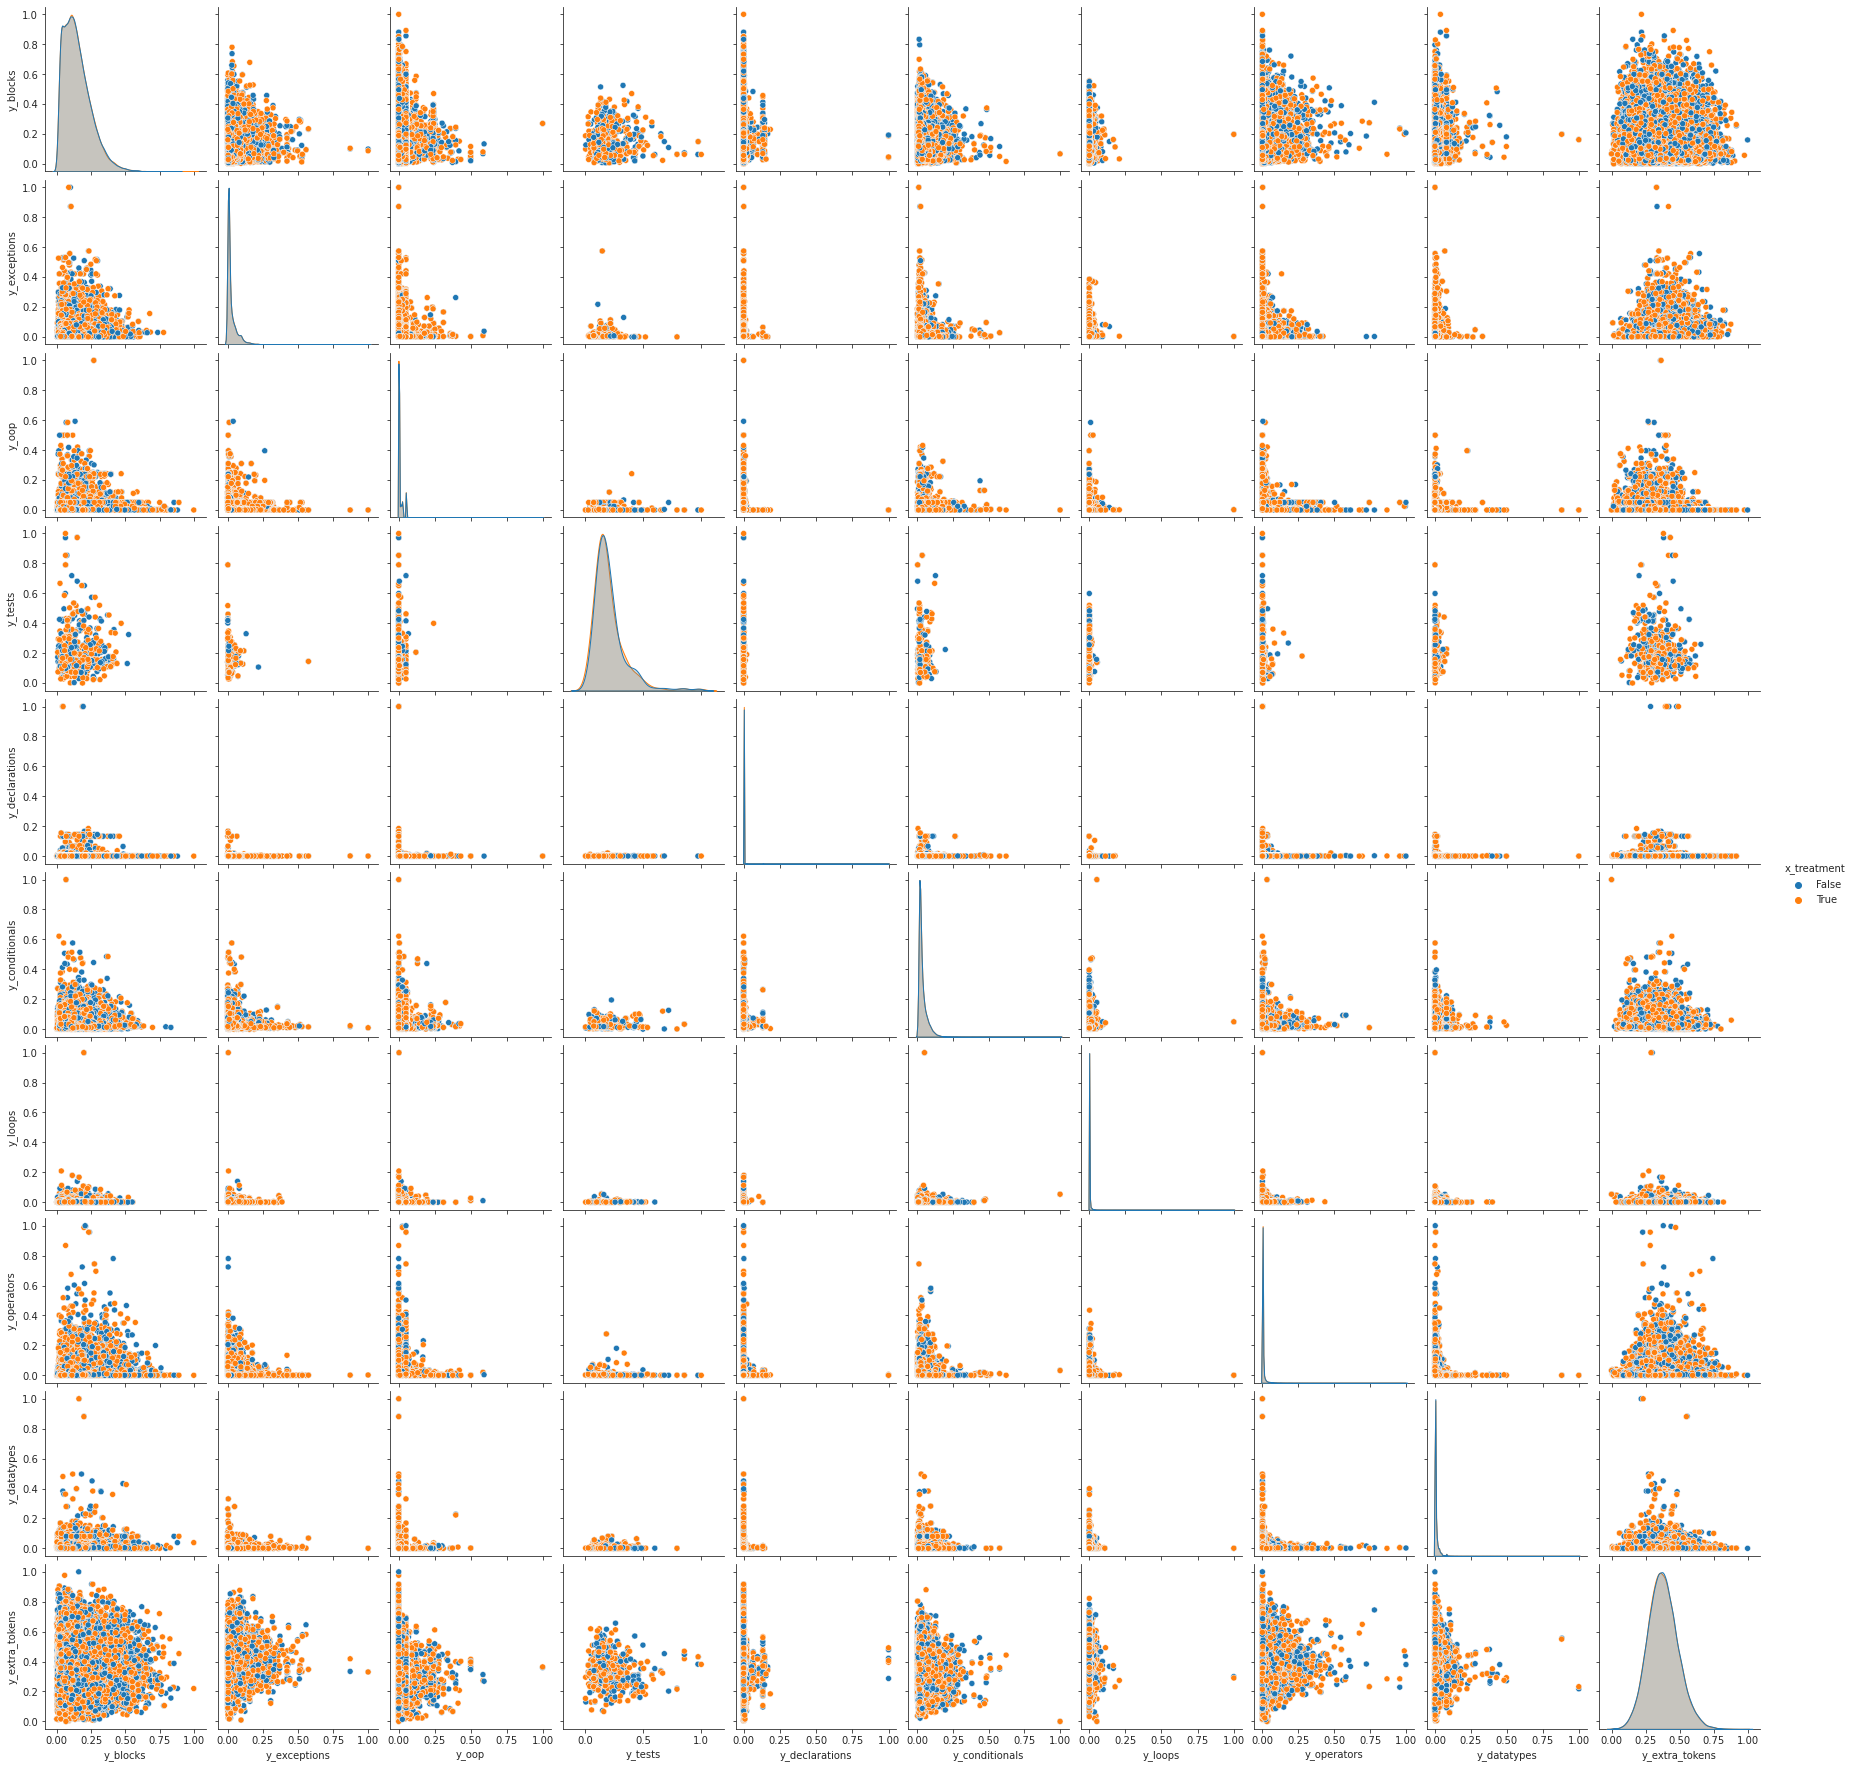

In [272]:
sns.set_style("ticks")
k = sns.pairplot(df_error_tax_scaled, hue="x_treatment")

In [167]:
#export
def bootstrapping( np_data, np_func, cov, size=500 ):
    """Create a bootstrap sample given data and a function
    For instance, a bootstrap sample of means, or mediands. 
    The bootstrap replicates are a long as the original size
    we can choose any observation more than once (resampling with replacement:np.random.choice)
    """
    
    #Cleaning NaNs
    np_data_clean = np_data[ np.logical_not( np.isnan(np_data) ) ] 
    
    #The size of the bootstrap replicate is as big as size
    #Creating the boostrap replicates as long as the orignal data size
    #This strategy might work as imputation 
    bootstrap_repl = [ np_func( np.random.choice( np_data_clean, size=len(np_data) ) ) for i in range( size ) ]
    
    logging.info("Covariate: " + cov) #Empirical Mean
    logging.info("Empirical Mean: " + str(np.mean(np_data_clean))) #Empirical Mean
    logging.info("Bootstrapped Mean: " + str( np.mean(bootstrap_repl) ) ) #Bootstrapped Mean
    
    return np.array(bootstrap_repl)

In [141]:
#export
#We use normal distribution assuming the sample size is big enough (~more than 100 points)
def confidence_intervals_v1(np_data_bs, conf=0.95):
    """Confidence Intervals with Gaussian Distribution (n>=30)"""
    CI = stats.norm.interval(alpha=conf, loc = np.mean( np_data_bs ), scale = stats.sem(np_data_bs))
    logging.info( CI )
    return CI

In [172]:
#export
#see https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def confidence_intervals_v2(data, confidence=0.95):
    dist = NormalDist.from_samples(data)
    z = NormalDist().inv_cdf((1 + confidence) / 2.)
    h = dist.stdev * z / ((len(data) - 1) ** .5)
    return dist.mean - h, dist.mean + h, h

In [92]:
#tst
ret_temp = bootstrapping(  df_error_tax_scaled.y_blocks.values, np.mean )

2021-07-14 20:07:52,811 : INFO : Empirical Mean: 0.14906472584319005
2021-07-14 20:07:52,812 : INFO : Bootstrapped Mean: 0.1490742844967155


In [142]:
#tst
confidence_intervals(ret_temp)

2021-07-14 21:04:10,816 : INFO : (0.14904787304317768, 0.14910069595025333)


(0.14904787304317768, 0.14910069595025333)

In [87]:
df_control_tax_scaled = df_error_tax_scaled.loc[lambda row: row['x_treatment'] == True  ].copy()
df_treatment_tax_scaled = df_error_tax_scaled.loc[lambda row: row['x_treatment'] == False  ].copy()

In [100]:
df_control_tax_scaled_bs = [ bootstrapping( df_control_tax_scaled[out].values, np.mean, out, 5000 ) for out in potential_outcomes ]

2021-07-14 20:13:22,796 : INFO : Covariate: y_blocks
2021-07-14 20:13:22,797 : INFO : Empirical Mean: 0.1489916757729206
2021-07-14 20:13:22,798 : INFO : Bootstrapped Mean: 0.14899795798838095
2021-07-14 20:13:24,980 : INFO : Covariate: y_exceptions
2021-07-14 20:13:24,981 : INFO : Empirical Mean: 0.02685317635571769
2021-07-14 20:13:24,982 : INFO : Bootstrapped Mean: 0.026853741630826322
2021-07-14 20:13:27,347 : INFO : Covariate: y_oop
2021-07-14 20:13:27,349 : INFO : Empirical Mean: 0.009301499134348567
2021-07-14 20:13:27,350 : INFO : Bootstrapped Mean: 0.009301548164190359
2021-07-14 20:13:31,721 : INFO : Covariate: y_tests
2021-07-14 20:13:31,721 : INFO : Empirical Mean: 0.1997741184551925
2021-07-14 20:13:31,722 : INFO : Bootstrapped Mean: 0.19978796317392988
2021-07-14 20:13:36,374 : INFO : Covariate: y_declarations
2021-07-14 20:13:36,375 : INFO : Empirical Mean: 0.0007738889654250232
2021-07-14 20:13:36,376 : INFO : Bootstrapped Mean: 0.0007739386288381057
2021-07-14 20:13:42

In [185]:
df_treatment_tax_scaled_bs = [ bootstrapping( df_treatment_tax_scaled[out].values, np.mean, out, 5000 ) for out in potential_outcomes ]

2021-07-14 22:00:54,837 : INFO : Covariate: y_blocks
2021-07-14 22:00:54,838 : INFO : Empirical Mean: 0.14913777591345959
2021-07-14 22:00:54,839 : INFO : Bootstrapped Mean: 0.14913674015916303
2021-07-14 22:00:57,020 : INFO : Covariate: y_exceptions
2021-07-14 22:00:57,020 : INFO : Empirical Mean: 0.026803362000868414
2021-07-14 22:00:57,021 : INFO : Bootstrapped Mean: 0.02680031950526146
2021-07-14 22:00:59,411 : INFO : Covariate: y_oop
2021-07-14 22:00:59,413 : INFO : Empirical Mean: 0.009297876012892085
2021-07-14 22:00:59,414 : INFO : Bootstrapped Mean: 0.009298340933375568
2021-07-14 22:01:03,924 : INFO : Covariate: y_tests
2021-07-14 22:01:03,925 : INFO : Empirical Mean: 0.20607448652900986
2021-07-14 22:01:03,926 : INFO : Bootstrapped Mean: 0.2060900871204755
2021-07-14 22:01:08,590 : INFO : Covariate: y_declarations
2021-07-14 22:01:08,591 : INFO : Empirical Mean: 0.000766948754979761
2021-07-14 22:01:08,592 : INFO : Bootstrapped Mean: 0.0007673866442185774
2021-07-14 22:01:14

In [111]:
df_control_tax_scaled_bs = pd.DataFrame(np.array(df_control_tax_scaled_bs).T, columns = potential_outcomes)

In [186]:
df_treatment_tax_scaled_bs = pd.DataFrame(np.array(df_treatment_tax_scaled_bs).T, columns = potential_outcomes)

In [112]:
df_control_tax_scaled_bs.head(1)

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens
0,0.149009,0.027032,0.009252,0.20003,0.000816,0.034,0.002488,0.006078,0.007244,0.375374


In [187]:
df_treatment_tax_scaled_bs.head(1)

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens
0,0.148894,0.026608,0.009299,0.205542,0.000747,0.034067,0.0025,0.006059,0.007269,0.376117


In [188]:
#vector of confidence intervals
v_CI_control = [confidence_intervals_v2(df_control_tax_scaled_bs[out].values) for out in potential_outcomes ]
v_CI_treatment = [confidence_intervals_v2(df_treatment_tax_scaled_bs[out].values) for out in potential_outcomes ]

In [189]:
#Last Column h values
np.array(v_CI_control).T[-1]

array([1.07370515e-05, 5.06143667e-06, 2.38213086e-06, 1.55032880e-05,
       1.04942383e-06, 3.44560099e-06, 1.09934153e-06, 2.61365732e-06,
       1.99112018e-06, 1.21439733e-05])

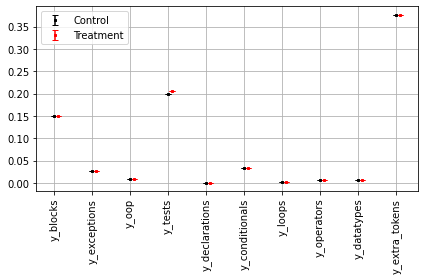

In [196]:
#Plotting Confidence Intervals

x_1 = np.arange(1, len(potential_outcomes)+1)
x_2 = x_1 + 0.1

y_1 = df_control_tax_scaled_bs.mean().values
y_2 = df_treatment_tax_scaled_bs.mean().values

err_1 = np.array(v_CI_control).T[-1]
err_2 = np.array(v_CI_treatment).T[-1]

plt.errorbar(x=x_1, y=y_1, yerr=err_1, color="black", capsize=3,
             linestyle="None",
             marker="s", markersize=2, mfc="black", mec="black", label="Control")

plt.errorbar(x=x_2, y=y_2, yerr=err_2, color="red", capsize=3,
             linestyle="None",
             marker="s", markersize=2, mfc="red", mec="red", label="Treatment")

plt.xticks(x_1, potential_outcomes, rotation=90)

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [198]:
#Control and Treatment Concated
df_error_tax_scaled_bs = pd.concat([df_control_tax_scaled_bs,df_treatment_tax_scaled_bs])

In [199]:
df_error_tax_scaled_bs.head(1)

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens
0,0.149009,0.027032,0.009252,0.20003,0.000816,0.034,0.002488,0.006078,0.007244,0.375374


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6067f3c970>,
      dtype=object)

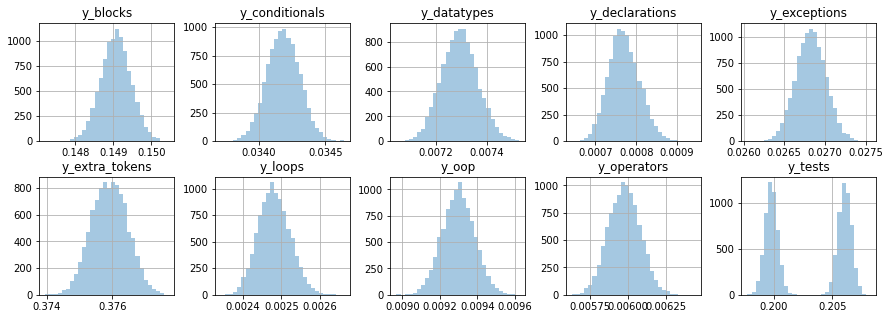

In [200]:
#This Plot Makes sense for the control and treatment at the same time
df_error_tax_scaled_bs[potential_outcomes].hist(
    bins=30, 
    alpha=0.4, 
    layout=(2, 5), 
    figsize = (15,5),
)

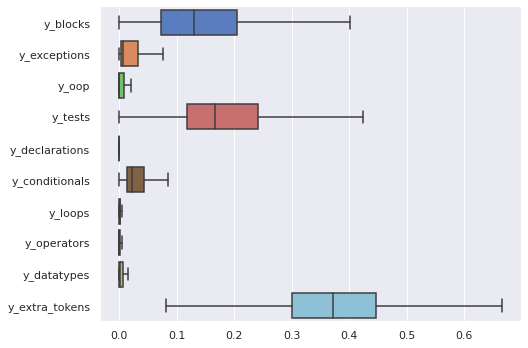

In [286]:
sns.set_theme(style="darkgrid")

f = sns.catplot(
    #x="fare", 
    #y=potential_outcomes, 
    #row="class",
    #col = 'x_treatment',
    kind="box", 
    orient="h", 
    height=5, 
    aspect=1.5,
    palette="muted",
    data=df_error_tax_scaled[potential_outcomes],
    showfliers = False
)

#f.set(xscale="log")

## EDA Cross-Entropy Analysis
This dataset is for testing purpuses

In [15]:
df_cross_entr = pd.read_json(
            params['bug_entropy'], orient="records", lines=True
        )

ValueError: Expected object or value

In [205]:
df_cross_entr.head(1)

,transformed_code,y_cross_entropy,x_treatment,original_code,z_count_subwords,file,class,z_wmc,z_totalMethodsQty,z_staticMethodsQty,...,z_numbersQty,z_assignmentsQty,z_mathOperationsQty,z_variablesQty,z_maxNestedBlocksQty,z_anonymousClassesQty,z_innerClassesQty,z_lambdasQty,z_uniqueWordsQty,z_modifiers
0,<private> <void> success<(>io.netty.channel.Ch...,6.00622,False,private void success(io.netty.channel.Channel ...,177,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord0,1,1,0,...,1,3,0,2,0,0,0,0,8,1


In [207]:
df_cross_entr.describe()

,y_cross_entropy,z_count_subwords,z_wmc,z_totalMethodsQty,z_staticMethodsQty,z_publicMethodsQty,z_privateMethodsQty,z_protectedMethodsQty,z_defaultMethodsQty,z_abstractMethodsQty,...,z_numbersQty,z_assignmentsQty,z_mathOperationsQty,z_variablesQty,z_maxNestedBlocksQty,z_anonymousClassesQty,z_innerClassesQty,z_lambdasQty,z_uniqueWordsQty,z_modifiers
count,129444.000000,129444.000000,129444.000000,129444.0,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000,...,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000,129444.000000,129444.0
mean,6.142502,185.407628,2.482417,1.0,0.128449,0.704490,0.207634,0.065441,0.022434,0.792366,...,0.913654,1.884583,0.571336,1.232247,1.018572,0.023122,0.000348,0.006080,11.336732,1.0
std,1.510858,64.357274,1.309905,0.0,0.334591,0.456273,0.405615,0.247304,0.148092,0.405615,...,1.720107,1.580910,1.363303,1.161180,0.830400,0.157225,0.020232,0.092444,4.994894,0.0
min,2.066005,68.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.0
25%,5.038853,143.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.0
50%,5.982966,176.000000,2.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,10.000000,1.0
75%,7.085069,216.000000,3.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,3.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,13.000000,1.0
max,12.283474,4465.000000,18.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,41.000000,19.000000,21.000000,11.000000,6.000000,4.000000,2.000000,5.000000,336.000000,1.0


In [209]:
df_control_cross_entr = df_cross_entr.loc[lambda row: row['x_treatment'] == True  ].copy()
df_treatment_cross_entr = df_cross_entr.loc[lambda row: row['x_treatment'] == False  ].copy()

In [212]:
df_control_cross_entr_bs =  bootstrapping( df_control_cross_entr['y_cross_entropy'].values, np.mean, 'y_cross_entropy_control', 5000 )
df_treatment_cross_entr_bs =  bootstrapping( df_treatment_cross_entr['y_cross_entropy'].values, np.mean, 'y_cross_entropy_treatment', 5000 )

2021-07-15 04:21:33,032 : INFO : Covariate: y_cross_entropy_control
2021-07-15 04:21:33,033 : INFO : Empirical Mean: 6.1361528353440695
2021-07-15 04:21:33,034 : INFO : Bootstrapped Mean: 6.136123927147603
2021-07-15 04:21:35,381 : INFO : Covariate: y_cross_entropy_treatment
2021-07-15 04:21:35,382 : INFO : Empirical Mean: 6.148851065600141
2021-07-15 04:21:35,383 : INFO : Bootstrapped Mean: 6.1489268858340855


In [217]:
#vector of confidence intervals
w_CI_control = confidence_intervals_v2(df_control_cross_entr_bs) 
w_CI_treatment = confidence_intervals_v2(df_treatment_cross_entr_bs) 

In [218]:
w_CI_control,w_CI_treatment

((6.135960204556351, 6.136287649738854, 0.0001637225912511652),
 (6.148762656490593, 6.149091115177578, 0.00016422934349214462))

In [214]:
df_cross_entr_bs = pd.DataFrame(
    np.array([df_control_cross_entr_bs,df_treatment_cross_entr_bs]).T, 
    columns = ['y_cross_entropy_control','y_cross_entropy_treatment'])

In [215]:
df_cross_entr_bs.head(1)

,y_cross_entropy_control,y_cross_entropy_treatment
0,6.138441,6.152264


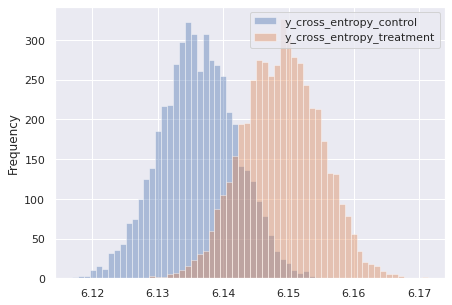

In [287]:
sns.set_theme(style="darkgrid")
df_cross_entr_bs.plot.hist(
    bins=60, 
    alpha=0.4,
    figsize=(7,5)
)

In [ ]:
# Compute frequency and bins
frequency, bins = np.histogram(x, bins=10, range=[0, 100])

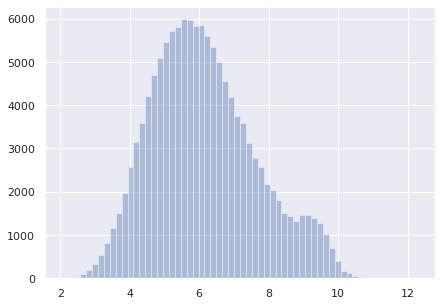

In [288]:
sns.set_theme(style="darkgrid")
df_cross_entr['y_cross_entropy'].hist(
    bins=60, 
    alpha=0.4,
    figsize=(7,5)
)